# Chapter 6: The Haunted DAG & The Causal Terror - Exercises

**6E1** List three mechanisms by which multiple regression can produce false inferences about causal effects.

Answer:

1. Collider Bias
2. Post-Treatment Bias
3. Multicollinearity

**6E2** For one of the mechanisms in the previous problem, provide an example of your choice, perhaps from your own research.

Answer:

Restaurants in the city can have a tendency to be worse than in more rural settings. This happens because we only survey restaurants that survive, which is itself a variable. This variable is a **collider** because it is caused by both the quality of the restaurant and the location.

**6E3** List the four elemental confounds. Can you explain the conditional dependencies of each?

Answer:

1. Fork. Z causes A and B. Conditional on Z, A is independent of B.
2. Pipe. A causes B which causes C. A and C are independent, conditional on B.
3. Collider. A and B causes C. A and B are independent of each other, but conditioning on C brings a spurious association.
4. Descendant. Similar to Collider, but C causes D which has less information than C.

**6E4** How is a biased sample like conditioning on a collider? Think of the example at the open of the chapter.

Answer: Same as answer 6E2.

**6M1** Modify the DAG on page 186 to include the variable V, an unobserved cause of C and Y: C ← V → Y. Reanalyze the DAG. How many paths connect X to Y? Which must be closed? Which variables should you condition on now?

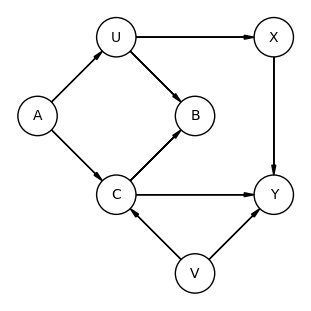

In [1]:
import daft
from causalgraphicalmodels import CausalGraphicalModel
from matplotlib import pyplot as plt

dag = CausalGraphicalModel(
    nodes=['X', 'Y', 'C', 'U', 'B', 'A', 'V'],
    edges=[
        ('X', 'Y'),
        ('U', 'X'),
        ('A', 'U'),
        ('A', 'C'),
        ('C', 'Y'),
        ('U', 'B'),
        ('C', 'B'),
        ('V', 'C'),
        ('V', 'Y'),
    ],
)
pgm = daft.PGM()
coordinates = {
    'X': (3, 0), 'Y': (3, 2), 'C': (1, 2), 
    'U': (1, 0), 'B': (2, 1), 'A': (0, 1),
    'V': (2, 3),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

In [2]:
all_adjustment_sets = dag.get_all_backdoor_adjustment_sets('X', 'Y')
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {'U'}:
            print(s)

frozenset({'A'})
frozenset({'C', 'V'})


**6M2** Sometimes, in order to avoid multicollinearity, people inspect pairwise correlations among predictors before including them in a model. This is a bad procedure, because what matters is the conditional association, not the association before the variables are included in the model. To highlight this, consider the DAG X → Z → Y. Simulate data from this DAG so that the correlation between X and Z is very large. Then include both in a model prediction Y. Do you observe any multicollinearity? Why or why not? What is different from the legs example in the chapter?

In [3]:
import numpy as np
from scipy import stats

np.random.seed(42)
x = np.random.normal(size=10000)
z = np.random.normal(loc=x*2)
y = np.random.normal(loc=z*4)

stats.pearsonr(x, y)

PearsonRResult(statistic=0.8881082149119461, pvalue=0.0)

In [5]:
import pymc as pm
from rethinking import quap, precis
import pandas as pd


with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    bx = pm.Normal('bx', 1, 100)
    bz = pm.Normal('bz', 1, 100)
    a = pm.Normal('a', 1, 100)
    mu = pm.Deterministic('mu', a + bx * x + bz * z)
    yo = pm.Normal('yo', mu, sigma, observed=y)
    
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
post_data = pd.DataFrame(post.rvs(10_000), columns=var_names)
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,0.990607,0.007168,0.978978,1.002234
bx,-0.026606,0.022127,-0.061911,0.009343
bz,4.026628,0.009869,4.010875,4.042445
a,-0.012681,0.009829,-0.028255,0.002890


As expected from a **Pipe**, X is independent of Y when conditioned on Z. Although we can identify high collinearity, it isn't the same as the leg problem, since one causes the other instead of having another unobserved variable causing both.

**6M3** Learning to analyze DAGs requires practice. For each of the four DAGs below, state which variables, if any, you must adjust for (condition on) to estimate the total causal influence of X on Y.

Answer:

1. Top Left: Z
2. Top Right: {}
3. Bottom Left: {}
4. Bottom Right: A

**6H1** Use the Waffle House data, data(WaffleDivorce), to find the total causal influence of number of Waffle Houses on divorce rate. Justify your model or models with a causal graph.

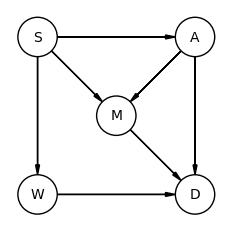

In [8]:
dag = CausalGraphicalModel(
    nodes=['S', 'W', 'D', 'A', 'M'],
    edges=[
        ('S', 'W'),
        ('W', 'D'),
        ('A', 'D'),
        ('S', 'A'),
        ('S', 'M'),
        ('M', 'D'),
        ('A', 'M'),
    ],
)
pgm = daft.PGM()
coordinates = {
    'S': (0, 0), 'W': (0, 2), 'D': (2, 2), 
    'A': (2, 0), 'M': (1, 1),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

To close the S Fork, we can condition on it. It is also possible to condition on both A and M.

In [12]:
from rethinking import DATA_PATH, standardize

d = pd.read_csv(DATA_PATH.joinpath('WaffleDivorce.csv'), sep=';')

In [15]:
W = standardize(d['WaffleHouses'].values)
Do = standardize(d['Divorce'].values)
S = d['South'].values

In [16]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', 0, 0.2, shape=2)
    bW = pm.Normal('bW', 0, 0.5)
    mu = pm.Deterministic('mu', a[S] + bW*W)
    D = pm.Normal('D', mu, sigma, observed=Do)
    post, vars_ = quap(model)

precis(post, ['sigma', 'a0', 'a1', 'bW'])

,mean,std,5.5%,94.5%
sigma,0.942872,0.100266,0.785273,1.106619
a0,-0.087527,0.130014,-0.295912,0.118942
a1,0.143212,0.169601,-0.129057,0.417621
bW,0.171624,0.142803,-0.058422,0.398738


In this model, we can see that the causal effect of Waffle houses on Divorce rate is very small.

**6H2** Build a series of models to test the implied conditional independencies of the causal graph you used in the previous problem. If any of the tests fail, how do you think the graph needs to be amended? Does the graph need more or fewer arrows? Feel free to nominate variables that aren’t in the data.

In [17]:
dag.get_all_independence_relationships()

[('D', 'S', {'A', 'M', 'W'}),
 ('A', 'W', {'S'}),
 ('A', 'W', {'M', 'S'}),
 ('M', 'W', {'S'}),
 ('M', 'W', {'A', 'S'})]

To test these models, we need to check if we consider all the variables, then the relationship between one and the other will be close to 0.

**6H3** Use a model to infer the total causal influence of area on weight. Would increasing the area available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the possible outcome range